In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
set.seed(1)

In [3]:
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeHeadway')
valuables <- c("RoadType","CurveAverage","Speed", "Curve100", "Curve150","MaxSpeed","RiskFactor","Curve","DistSignal","Pitch","AheadDistance","AverageVelocity","TimeToCollision","AccelerationSpeed", "Engine", "SteeringAngle", "TimeHeadway", "Jerk", "LaneCount", "DiffAvgSpeed", "EmptinessOfRoad", "RoadFactor")

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
trainAndPredict <- function(dfx, verbose=FALSE) {        
    train <- dfx[, c(valuables, "flag")]
    test <- dfx
    fit <- rpart(flag ~ ., data=train)
    p <- predict(fit, newdata=test, cp=0.018)
    predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]

    showMatrix(test, predictedFlags)

    nerr <- sum(predictedFlags != test$flag)
}

In [6]:
showMatrix <- function(test, predictedFlags) {
    predictedRed <- test[predictedFlags == "Red", ]
    predictedBlue <- test[predictedFlags == "Blue", ]
    print(predictedRed %>% group_by(flag, AccelOrBrake) %>% summarize(count=n()))
    print(predictedBlue %>% group_by(flag, AccelOrBrake) %>% summarize(count=n()))
}

In [7]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [8]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [9]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [10]:
df3 <- read.csv("../data/middle/sp5.csv", stringsAsFactors=FALSE)

In [11]:
df3$AccelOrBrake[df3$flag == "RedA"] <- "Accel"
df3$AccelOrBrake[df3$flag == "RedB"] <- "Brake"
df3$AccelOrBrake[df3$flag == "BlueA"] <- "Accel"
df3$AccelOrBrake[df3$flag == "BlueB"] <- "Brake"

In [12]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [13]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [14]:
df3 %>% group_by(flag, AccelOrBrake) %>% summarize(count=n())

flag,AccelOrBrake,count
Blue,Accel,77
Blue,Brake,372
Red,Accel,401
Red,Brake,192


In [15]:
result <- trainAndPredict(df3, verbose=TRUE)

Source: local data frame [4 x 3]
Groups: flag [?]

    flag AccelOrBrake count
  <fctr>        <chr> <int>
1   Blue        Accel    43
2   Blue        Brake   142
3    Red        Accel   341
4    Red        Brake   155
Source: local data frame [4 x 3]
Groups: flag [?]

    flag AccelOrBrake count
  <fctr>        <chr> <int>
1   Blue        Accel    34
2   Blue        Brake   230
3    Red        Accel    60
4    Red        Brake    37


In [16]:
fit3 <- rpart(expr, data=df3, method="class")

In [17]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01

In [18]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
[1] AccelerationSpeed AccelOrBrake      Curve            

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.400891      0   1.00000 1.00000 0.035602
2 0.046771      1   0.59911 0.59911 0.031462
3 0.031180      2   0.55234 0.57238 0.030990
4 0.010000      3   0.52116 0.55234 0.030617


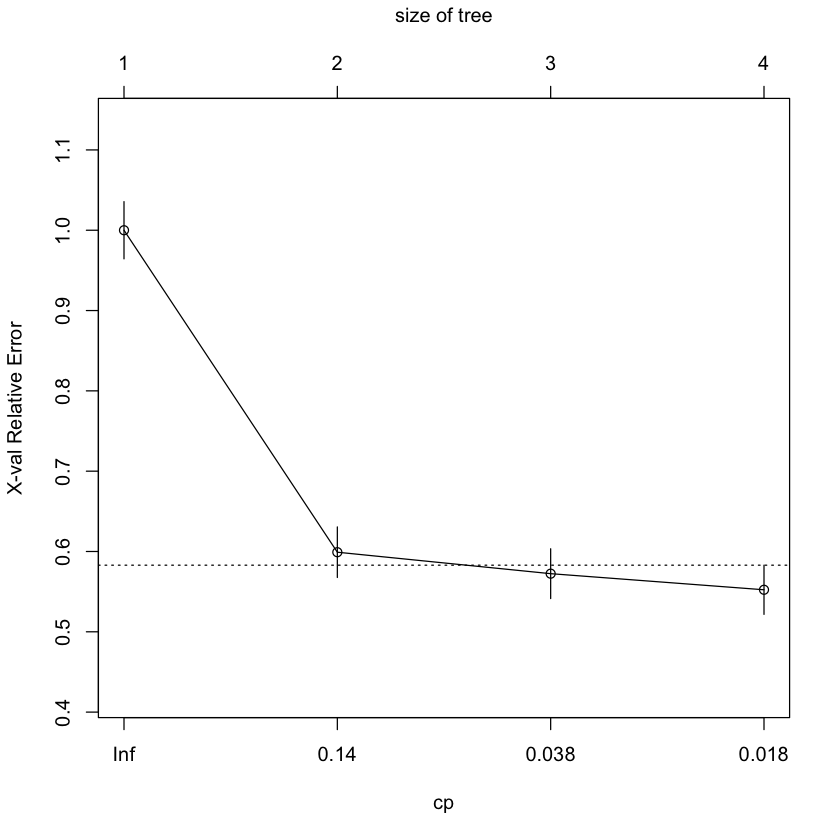

In [19]:
plotcp(fit3)

In [20]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

         CP nsplit rel error    xerror       xstd
1 0.4008909      0 1.0000000 1.0000000 0.03560167
2 0.0467706      1 0.5991091 0.5991091 0.03146195
3 0.0311804      2 0.5523385 0.5723831 0.03098997
4 0.0100000      3 0.5211581 0.5523385 0.03061652

Variable importance
     AccelOrBrake          RoadType   EmptinessOfRoad          MaxSpeed 
               39                12                11                 8 
            Speed        RiskFactor             Curve      CurveAverage 
                7                 7                 5                 5 
AccelerationSpeed     SteeringAngle 
                3                 1 

Node number 1: 1042 observations,    complexity param=0.4008909
  predicted class=Red   expected loss=0.4309021  P(node) =1
    class counts:   449   593
   probabilities: 0.431 0.569 
  left son=2 (564 obs) right son=3 (478 obs)
  Primary splits:
      AccelOrBrake  splits as  RL, improve=1

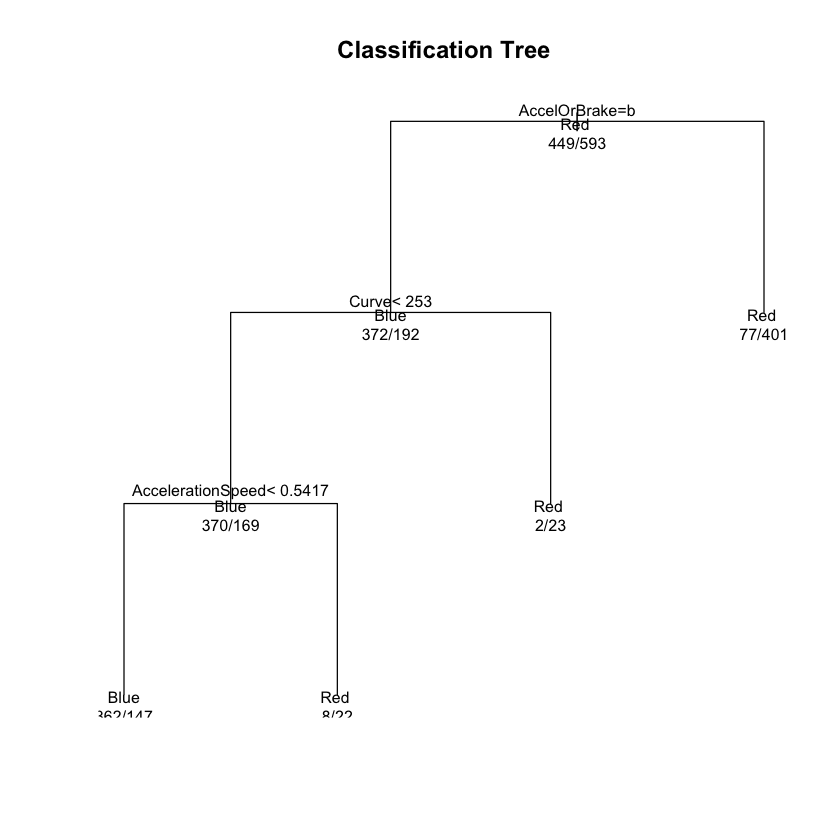

In [21]:
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.8)